<a href="https://colab.research.google.com/github/gabiacuna/KL2021/blob/main/Analisis%20de%20Imagenes%20con%20DL/004-Deteccion-de-Objetos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detección de Objectos

En este tutorial veremos como se puede utilizar Pytorch para entrenar un modelo de detección
de objetos.

Usaremos la base de datos [*Penn-Fudan Database for Pedestrian Detection and Segmentation*](https://www.cis.upenn.edu/~jshi/ped_html/)
y la entrenaremos utilizando un modelo de [Mask R-CNN](https://arxiv.org/abs/1703.06870). Este modelu incluye un total de
170 imágenes con 345 instancias de peatones, y lo usaremos para ver como podemos extraer "features" para entrenar un modelo

In [2]:
# Instalamos los paquetes necesarios
!pip install -r https://raw.githubusercontent.com/vcalderon2009/2021_06_Deep_Learning_tutorial/master/pkg_requirements.txt -q

ERROR: Double requirement given: ipython==7.0.1 (from -r https://raw.githubusercontent.com/vcalderon2009/2021_06_Deep_Learning_tutorial/master/pkg_requirements.txt (line 18)) (already in ipython (from -r https://raw.githubusercontent.com/vcalderon2009/2021_06_Deep_Learning_tutorial/master/pkg_requirements.txt (line 15)), name='ipython')


In [3]:
!pip install click
!pip install Sphinx
!pip install coverage
!pip install awscli
!pip install flake8
!pip install python-dotenv>=0.5.1
!pip install numpy
!pip install pandas
!pip install sklearn
!pip install matplotlib
!pip install seaborn
!pip install jupyterlab
!pip install ipython
!pip install nb-black
!pip install torch==1.8.1
!pip install black
!pip install matplotlib
!pip install torchviz
!pip install torchvision
!pip install scikit-image
!pip install wget
!pip install cython
!pip install pycocotools

  Using cached https://files.pythonhosted.org/packages/0b/49/f967808ae4ab111bb3057afd9f8483b45d3973990e6c259646d4fab97767/awscli-1.19.103-py2.py3-none-any.whl
     |████████████████████████████████| 7.7MB 29.3MB/s 
     |████████████████████████████████| 552kB 28.7MB/s 
     |████████████████████████████████| 81kB 10.1MB/s 
     |████████████████████████████████| 143kB 36.7MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Found existing installation: docutils 0.17.1
    Uninstalling docutils-0.17.1:
      Successfully uninstalled docutils-0.17.1
  Using cached https://files.pythonhosted.org/packages/fc/80/35a0716e5d5101e643404dabd20f07f5528a21f3ef4032d31a49c913237b/

  Using cached https://files.pythonhosted.org/packages/a9/86/195e7b1bcafe86c2f5deb3efcbdc6ab35f7269fc4b0095b94321de2215a2/nb_black-1.0.7.tar.gz
     |████████████████████████████████| 143kB 30.3MB/s 
     |████████████████████████████████| 747kB 27.3MB/s 
     |████████████████████████████████| 727kB 41.8MB/s 
  Created wheel for nb-black: filename=nb_black-1.0.7-cp37-none-any.whl size=5300 sha256=ee570615ba94a12cedabebcb3420d53e677c002c169e2723cbdd619c6ae61e31
  Stored in directory: /root/.cache/pip/wheels/35/6d/99/856a3401e3a2153f51223f1be990e4b30f80f9e4bd1604ae9b
Successfully built nb-black
  Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
     |████████████████████████████████| 804.1MB 20kB/s 
ERROR: torchvision 0.10.0+cu102 has requirement torch==1.9.0, but you'll have torch 1.8.1 which is incompatible.
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.8.1 which is incompat

## Dataset

Primero bajamos la base de datos en la carpeta actual:

In [4]:
# download the Penn-Fudan dataset
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
!unzip PennFudanPed.zip

--2021-07-01 00:38:57--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M   162MB/s    in 0.3s    

2021-07-01 00:38:58 (162 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2021-07-01 00:38:58--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2021-07-01 00:38:58--
Total wall clock time: 0.4s
Downloaded: 1 files, 51M in 0.3s (162 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennF

Ahora podemos ver la estructura de esta nueva carpeta:

```
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```

Cada una de estas imágenes tiene asociado las máscaras que enseñan en donde es que hay personas.

Por ejemplo, podemos ver una de estas imágenes:

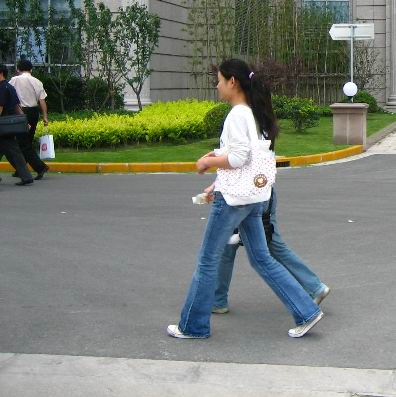

In [9]:
from PIL import Image

# Número de imagen
image_number = "00004"

Image.open(f'PennFudanPed/PNGImages/FudanPed{image_number}.png')

Y también podemos ver la **máscara** asociada a esta imagen:

In [7]:
Image

<module 'PIL.Image' from '/usr/local/lib/python3.7/dist-packages/PIL/Image.py'>

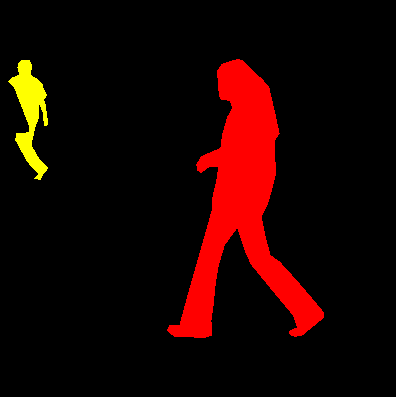

In [10]:
mask = Image.open(f'PennFudanPed/PedMasks/FudanPed{image_number}_mask.png')
# cada instancia de máscara tiene un color diferente, de cero a N, donde
# N es el número de instancias. Para facilitar la visualización,
# agreguemos paleta de colores a la máscara.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

Esto significal que cada imagen tiene una máscara de segmentación asociada, en donde el color corresponde a las
diferentes instancias.

## Dataloader

La siguiente parte es el **Dataset**, en donde se define como leer y ejecutar la data:

In [11]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image

In [12]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # Lee todas las imágenes y las ordena para ver que estén todas alineadas
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # Leyendo las imágenes y máscaras
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # NOTE: tenga en cuenta que no hemos convertido la máscara a RGB,
        # porque cada color corresponde a una instancia diferente
        # siendo 0 el fondo
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # las instancias están codificadas como colores diferentes
        obj_ids = np.unique(mask)
        # la primera identificación es el fondo, así que elimínela
        obj_ids = obj_ids[1:]

        # dividir la máscara codificada por colores en un conjunto
        # de máscaras binarias
        masks = mask == obj_ids[:, None, None]

        # obtener las coordenadas del cuadro delimitador para cada máscara
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Solamente hay una clase para acá
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # supongamos que no todas las instancias son multitud
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

Ahora que ya hemos definido el objecto del `Dataset`, podemos ver como se estructura los objetos:

In [13]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[100]

(<PIL.Image.Image image mode=RGB size=492x391 at 0x7F89A9279F50>,
 {'area': tensor([23220., 33748., 29348.]),
  'boxes': tensor([[125.,  92., 211., 362.],
          [203.,  80., 321., 366.],
          [346.,  88., 462., 341.]]),
  'image_id': tensor([100]),
  'iscrowd': tensor([0, 0, 0]),
  'labels': tensor([1, 1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  

Este objecto devuelve lo siguite:
- La imágen en formato de `PIL.image`.
- Un diccionario con el metadata de `boxes`, `labels`, y `masks`. Toda esta información se puede utilizar para entrenar un modelo.

### Modelaje

En este tutorial, usaremos [Mask R-CNN](https://arxiv.org/abs/1703.06870), el cual está basado en la red neural [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN
es un modelo que predice tanto cuadros delimitadores como puntuaciones de clase para objetos potenciales en la imagen.

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

Mask R-CNN agrega una rama adicional a Faster R-CNN, que también predice máscaras de segmentación para cada instancia.

![Mask R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image04.png)

##### Entrenando el modelo

Para este tutorial usaremos un modelo que ya ha sido entrenado previamente, y utilizaremos las pesas
de este modelo para aplicarlo a nuestra base de datos:

In [17]:
import torchvision

In [ ]:
#torchvision.models.

In [14]:
# Importamos los módulos necesarios, como los modelos y demás
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # En este caso, estamos cargando ya un modelo entrenado de RESNET sobre la
    # base de COCO.
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # Obtenemos el número de características de entrada para el clasificador
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Reemplazamos la cabeza previamente entrenada por una nueva.
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Ahora podemos obtener el número de características de entrada para el clasificador de máscara
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

Ahora necesitamos copiar unos archivos de `Pytorch` para usarlos acá:

In [23]:
#!git clone https://github.com/pytorch/vision.git
!cd vision
#!git checkout v0.3.0

!cp vision/references/detection/utils.py ../
!cp vision/references/detection/transforms.py ../
!cp vision/references/detection/coco_eval.py ../
!cp vision/references/detection/engine.py ../
!cp vision/references/detection/coco_utils.py ../

Y ahora podemos escribir las funciones para transformar las imágenes:

In [24]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

ModuleNotFoundError: ignored

Ahora creamos el dataset total:

In [ ]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

Y empezamos el entrenamiento del modelo:

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Iteramos sobre el diferente número de épocas:

In [ ]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

#### Evaluciación del modelo

Ahora podemos ver que tan bien aprendió el modelo:

In [ ]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [ ]:
# Y esta es la máscara
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())